# Нормализация

Что такое нормализация? И зачем она нужна? Давайте рассмотрим на примере решения задачи.

## Создание модели

Давайте создадим простую модель, чтобы проанализировать некоторые характеристики.

Как пример, давайте возьмем датасет с площадки Kaggle. Решать мы будем задачу предсказания длины поездки на такси. [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.csv', header=0, sep=',', quotechar='"')

In [2]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Отфильтруем дату посадки по убыванию, чтобы решать задачу для "будущих поездок", а в дальнейшем мы хотим будем предсказывать поездки, которые будут совершенны после тренировки модели, а не в прошлом.

In [3]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df = df.sort_values(by='pickup_datetime')

Также давайте уберем время высадки пассажиров, иначе это не имеет смысла искать время поездки.

In [4]:
df = df.drop('dropoff_datetime', axis=1)

Также давайте уберем время высадки пассажиров, иначе это не имеет смысла искать время поездки.

In [5]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


Конечно же, не забываем разделить выборку на тренировочную и тестовую, чтобы потом проверить качество модели.

In [6]:
df_train = df[:700_000]
df_test = df[700_000:900_000]

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на целевую переменную.

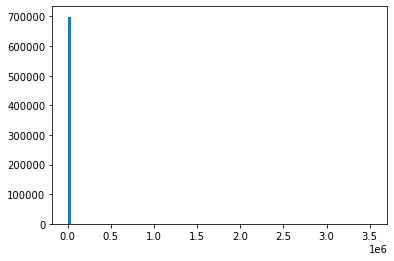

In [7]:
df_train.trip_duration.hist(bins=100, grid=False, )

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мнгновенно завершились. 

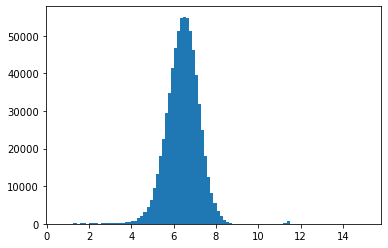

In [8]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [9]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

<ipython-input-9-05311ce01512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
<ipython-input-9-05311ce01512>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)


In [10]:
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849,6.745236
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294,7.166266
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408,6.013715
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280,5.638355
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736,6.602588


А теперь, давайте попробуем нарисовать сколько и в какие дни было поездок на такси.

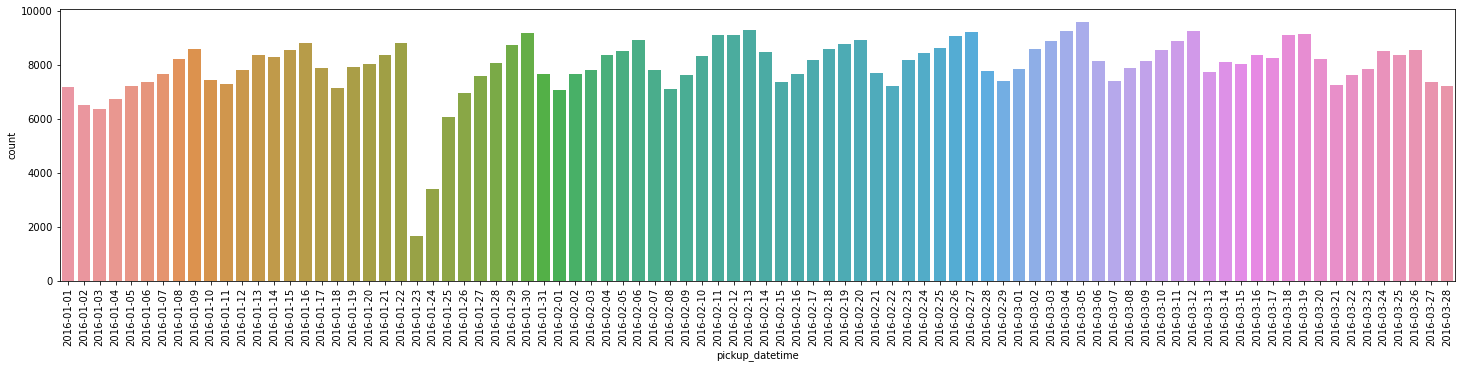

In [11]:
date_sorted = df_train.pickup_datetime.dt.date.sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

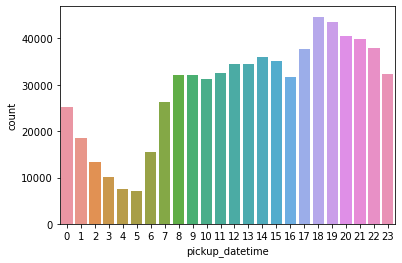

In [12]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
)

Опять же, выявляем некоторые закономерности в количестве поездок и временем, в которое они были произведены.

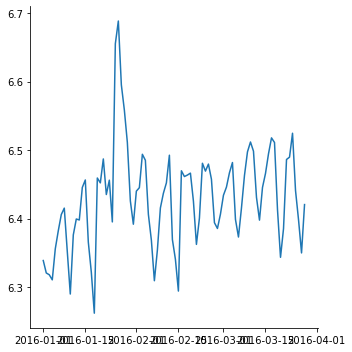

In [13]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.dt.date)
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

### Мы готовы создать и обучить модель

Мы уже поняли, что количество поездок как-то зависит от дня недели, времени суток, даты. Что же нам может помешать построить модель и обучить ее?

Хорошо, очень простая модель:

In [14]:
import datetime
def create_features(data_frame):
    X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),  # День года
      data_frame.pickup_datetime.apply(lambda x: x.hour),  # Час
     ], axis=1, keys=['day', 'hour',]
    )
  
    return X, data_frame.log_trip_duration

Данная функция просто создает нам матрицу признаков и матрицу ответов.

In [15]:
X_train, y_train = create_features(df_train)

In [16]:
X_test, y_test = create_features(df_test)

In [17]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


In [18]:
X_train[X_train["day"]==5]

,day,hour
780780,5,0
1170084,5,0
285880,5,0
140356,5,0
1204421,5,0
...,...,...
186066,5,23
1365860,5,23
1293391,5,23
908244,5,23


In [19]:
X_train[X_train["hour"]==23]

,day,hour
1221577,1,23
167517,1,23
265954,1,23
86338,1,23
171028,1,23
...,...,...
165119,88,23
282393,88,23
1367666,88,23
811061,88,23


In [20]:
X_train[(X_train["hour"]==23) & (X_train["day"]==5)]

,day,hour
1151514,5,23
480460,5,23
1397339,5,23
533435,5,23
666077,5,23
...,...,...
186066,5,23
1365860,5,23
1293391,5,23
908244,5,23


In [21]:
y_train

96469      6.745236
223872     7.166266
713067     6.013715
652463     5.638355
722901     6.602588
             ...   
165119     7.280008
282393     7.021084
1367666    7.225481
811061     6.109248
384712     6.689599
Name: log_trip_duration, Length: 700000, dtype: float64

Мы также можем увидеть наши размерности

In [22]:
X_train.shape

(700000, 2)

In [23]:
y_train.shape

(700000,)

# Для чего нужна нормализация?

Но давайте вернемся к нашей задаче, и подумаем почему же на данном этапе мы не можем обучить нашу модель?

Наши данные являются **ненормализованными**

Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. 

То есть у нас получается 2 веса. Один из которых умножается на день недели, а другой на наш час. Тогда, как можно подобрать 2 веса, чтобы точно предсказывать данные? Учитывая, что для модели числа 23 и число 0 абсолютно не имеет смысла. Очевидно, что никак. Ошибка модели будет достаточно большой, просто потому что мы подали на нее часы как вещественные числа.

И хотя модель сможет обучиться, но выдаст она результат **намного хуже**, чем могла бы. Давайте это проверим.

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
model = LinearRegression()

In [26]:
model.fit(X_train, y_train)

LinearRegression()

Модель обучена, сравним метрикой MSE

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
y_test.shape

(200000,)

In [29]:
model.predict(X_test).shape

(200000,)

In [30]:
a = mean_squared_error(y_test, model.predict(X_test))
a

0.6348846856282767

**Как видим, модель обучена плохо**

In [31]:
model.coef_

array([0.00068679, 0.0042205 ])

Наши веса модели

In [32]:
model.intercept_

6.341295630695556

Наше смещение модели

# Приводим нормализацию

Для начала стоит понимать, что под нормализацией в нейронных сетях воспринимают измененные данные, которые будут лежать в пределах от 0 до 1. Это значит, что вместо условного роста человека 180см, мы будем видеть какое-то вещественное число в промежутке $[0;1]$

Существует несколько способов нормализации данных. Рассмотрим их:

### 1) Деление на максимальное число.
Подходит для вещественных чисел типо роста, возраста и тд. Берем самое наибольшее значение выборки, далее все числа делим на него.   
Условно все данные были: (180, 170, 150, 100). А станут: (180/180, 170/180, 150/180, 100/180) -> (1, 0.94, 0.83, 0.55)  
Таким образом, мы привели все данные к числам от 0 до 1.

### 2) Z-нормализация

$$x_i^{norm} = \frac{(x_i-\overline X)}{S_x}, где$$

$$S_x = \frac{1}{N} \sum_{i=1}^N (x_i-\overline X)^2 $$

Это формула из теории вероятности. Важно понимать, что именно по ней скорее всего вычисляют нормализацию все библиотеки, поэтому ее можно не запоминать.

### 3) One-hot encoding

Обычно все так ее и называют, никто не говорит по-русски одно горячее кодирование) Хотя суть ясна еще из названия.  
Мы нормализуем наш признак с помощью 0 и 1, грубо говоря проверяя каждое на соответствие.

То есть условно, если мы хотим нормализовать число 8, зная при этом, что у нас есть числа от 0 до 9, то выглядеть это будет вот так:  
8 -> (0,0,0,0,0,0,0,0,**1**,0)

Соответственно, для всех чисел:  
0 -> (**1**,0,0,0,0,0,0,0,0,0)  
1 -> (0,**1**,0,0,0,0,0,0,0,0)  
2 -> (0,0,**1**,0,0,0,0,0,0,0)  
3 -> (0,0,0,**1**,0,0,0,0,0,0)  
...  
9 -> (0,0,0,0,0,0,0,0,0,**1**)  

Формально, мы объяснем это так:    
Первое число проверяет: "Это число 0?"  
Второе число проверяет: "Это число 1?"  и тд.

Таким образом, мы получаем не 1 вес, как было раньше, а уже, как на примере с цифрами 10. То есть к каждому новому 0 и 1 теперь будет присвоен свой вес. Для этого мы это и проделали.

# Возвращаемся к задаче

Для дней недели и часов будет не очень уместно использование первых двух способов нормализации, а вот нормализация с помощью one-hot, будет как раз кстати.

Таким образом, у нас будет свои веса для понедельника, вторника.... А не как было раньше - один вес для всех дней недели.

Давайте доделаем нашу модель с помощью one-hot encoding и сравним результат.

In [33]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

In [35]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [36]:
X_train = ohe.fit_transform(X_train)

In [37]:
X_train

array([[ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1., 88.],
       [ 0.,  0.,  0., ...,  0.,  1., 88.],
       [ 0.,  0.,  0., ...,  0.,  1., 88.]])

In [38]:
X_test = ohe.transform(X_test)

In [39]:
X_test

array([[  0.,   0.,   0., ...,   0.,   1.,  88.],
       [  0.,   0.,   0., ...,   0.,   1.,  88.],
       [  0.,   0.,   0., ...,   0.,   1.,  88.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 112.],
       [  0.,   0.,   0., ...,   0.,   0., 112.],
       [  0.,   0.,   0., ...,   0.,   0., 112.]])

Давайте теперь обучим модель

In [40]:
model_with_normalize = LinearRegression().fit(X_train, y_train)

In [ ]:
model_with_normalize = LinearRegression()

In [41]:
b = mean_squared_error(y_test, model_with_normalize.predict(X_test))
b

0.6279079105739971

In [42]:
model_with_normalize.coef_

array([2.52026589e+10, 2.52026589e+10, 2.52026589e+10, 2.52026589e+10,
       2.52026589e+10, 2.52026589e+10, 2.52026589e+10, 2.52026589e+10,
       2.52026589e+10, 2.52026589e+10, 2.52026589e+10, 2.52026589e+10,
       2.52026589e+10, 2.52026589e+10, 2.52026589e+10, 2.52026589e+10,
       2.52026589e+10, 2.52026589e+10, 2.52026589e+10, 2.52026589e+10,
       2.52026589e+10, 2.52026589e+10, 2.52026589e+10, 2.52026589e+10,
       7.18351318e-04])

Веса нашей модели

In [43]:
model_with_normalize.intercept_

-25202658849.616386

Смещение  
P.s. почему числа такие большие? Узнаете об этом на уроке про переобучение)

In [44]:
a - b

0.006976775054279627

Мы нашли разницу. И хоть она выглядит как очень маленькое число, стоит понимать, что это число на самом деле не совсем отражает суть нашей картины, а во-вторых в больших моделях очень много параметров, а как следствие мы можем улучшить нашу модель, добавив просто нормализацию, что мы и проделали сейчас на практике.

In [72]:
X_train.shape

(700000, 25)

## Еще один плюс нормализации

По весам мы можем смотреть как бы коэффицент, с которым признак влияет на наш ответ. Так вот, если все наши параметры будут нормализованы, то смотря по тому, насколько большим был наш вес, мы сможем понять насколько сильно тот или иной параметр влияет на нашу модель.

Условный пример.

На цену квартиры влияет:  
1) Количество комнат  
2) Количество квадратных метров  
3) Цена за квадратный метр  
4) Зарплата соседей  

Условно, если первые 2 критерия у нас будут измеряться в единицах, десятках и сотнях, то вот 3 и 4 признак у нас может измеряться в сотнях тысяч.

Тогда представим нашу модель как $w_1 * k_1 + w_2 * k_2 + w_3 * k_3 + w_4 * k_4 + w_0$

Условно, у нас $k_1, k_2$ лежат на промежутке  $[0; 100]$

А $k_3, k_4$ лежат на промежутке  $[25.000; 1.000.000]$

Тогда по нашим весам мы не сможем понять какой из признаков будет иметь больший "вес".  Ведь наши данные ненормализованы.